In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nfn import *

%matplotlib inline

In time series analysis [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) class of models is the basis for signal modelling and prediction. It’s a well researched mathematical tool with strong theoretical background and decades of practical applications. ARIMA states for "Auto-Regressive Integrated Moving Average". This model consists of two parts - Auto-Regressive and Moving Average forming another state-of-art model [ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model), and "integrated" means, that modelled time-series is an integrated ARMA process, i. e. finite differences of the series are modelled by ARMA. One useful representation of ARMA is in form of lag operator polynomials. Adding integration to make an ARIMA from ARMA means multiplying the initial equation by finite difference operator which is also linear. This makes ARIMA a linear model. This is also true for SARIMA (seasonal ARIMA), because seasonal components are still represented as lag polynomials. But linearity doesn’t always hold in real world problems, more to say it is quite rare. There are a lot of real world processes which cannot be precisely described by linear systems. One common scenario is multi-regime operation, where systems switches between several states, which abruptly changes the dynamics of the modelled time series. Application of linear models in such situations leads to larger errors. But this is where neo-fuzzy neuron becomes handy.

Neo-fuzzy neuron (NFN) was initialy described in \[1\]. It have been around for 25 years already but haven't gain much popularity except from [fuzzy logic](https://en.wikipedia.org/wiki/Fuzzy_logic) specialists. It has some nice features though. The NFN has the following scheme:

image here

$$NFN(\vec x) = \sum_{i=1}^{n} f_i(x_i) = \sum_{i=1}^{n} \sum_{j=1}^{m} w_{ij} \mu_{ij}(x_i)$$

Here $f_i(x_i)$ are fuzzy inference rules with triangular membership functions (MFs):

$$\mu(x, a, m ,b) = \begin{cases} 
    0, & x \leq a \\ 
    \frac{x - a}{m - a}, & a < x \leq m \\
    \frac{b - x}{b - m}, & m < x \leq b \\
    0, & x > b \end{cases}$$

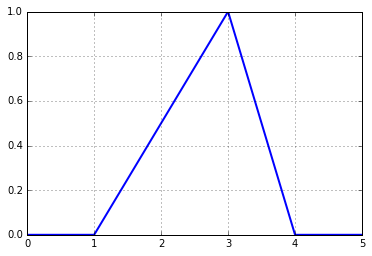

In [2]:
def triangular_mf(x, a, m, b):
    return np.maximum(0, np.minimum((x - a) / (m - a), (b - x) / (b - m)))

a = 1
m = 3
b = 4
x = np.linspace(a - 1, b + 1, (b - a + 2)*100)
plt.plot(x, triangular_mf(x, a, m, b), lw = 2)
plt.grid()

MFs in the inference rule must be complementary, so they add up to one in any point. Complementarity means, we can define a grid in the input domain, and this grid fully describes the collection of fuzzy sets in this space, so each MF depends only on it's center point $m$. 

In the original paper each inference rule $f_i(x_i)$ was a [Sugeno-type rule]() described in slightly different form:

$$f_i(x_i) = \sum_{j=1}^{m} w_{ij} \mu_(x_i, m_j)$$

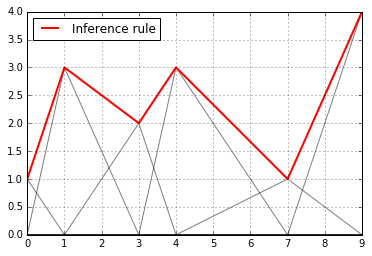

In [3]:
# define a grid on the inteval [0;9] and create a set
# of complementary MFs. 

grid = [-1, 0, 1, 3, 4, 7, 9, 10]
w    = [    1, 3, 2, 3, 1, 4    ]
x = np.linspace(grid[1], grid[-2], (grid[-2] - grid[1])*100).reshape(-1,1)
mfunc = get_asym_mfunc(np.array([grid]).T)
M = mfunc(x)
W = np.array([w]).T
Y = W[None,:,:] * M

for i in range(M.shape[1]):
    plt.plot(x, Y[:,i,0], 'k-', alpha = 0.5)
plt.plot(x, Y.sum(axis = (1,2)), 'r-', lw = 2, label = 'Inference rule')
plt.legend(loc = 'best')
plt.grid()

Now let's look closer in this inference rule and how it's related to time series modelling. Let's consider a toy example where there is some time series $x(t)$ which is fully contained in the interval $[\alpha,\beta]$. Now we design a trivial neo-fuzzy neuron for one-step prediction of this time series with one inference rule having two logical terms:

$$\hat{x_t} = NFN(x_{t-1}) = f_1(x_{t-1}) = w_1 \mu(x_{t-1}, \alpha-\beta, \alpha, \beta) + w_2 \mu(x_{t-1}, \alpha, \beta, \beta + \alpha) = w_1 \mu_\alpha(x_{t-1}) + w_2 \mu_\beta(x_{t-1})$$

For all valid values of $x(t)$ from the interval $[\alpha, \beta]$ and triangular complementary MFs the inference function of this rule is a linear function:

$$f(x_{t-1}) = \frac{w_1 \beta - w_2 \alpha}{\beta - \alpha} + \frac{w_2 - w_1}{\beta - \alpha} x_{t-1} = a_0 + a_1 x_{t-1} $$

Adding a noise terms $\epsilon_t$ to this we get an exact description of the AR(1) process with parameters $a_0$ and $a_1$. It's trivial to show that this equivalence holds for any AR(p) process. So here we outlined a simple proof of equivalence of AR(p) models and NFNs. There is a subtle detail though. An AR(p) process has $p + 1$ free parameters, while it's equivalent NFN - $2 p$ parameters. Because of this, if we'd wanted to write down equations of AR(p) coefficients in terms of NFN weights, resulting systed would be ill-defined (there is an infinite set of equivalent NFNs), so some form of regularization would be needed.

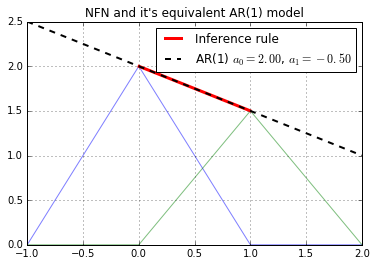

In [4]:
# construction of a trivial NFN and demonstration of 
# the equivalence to an AR(1) model

grid = [-1, 0,   1, 2]
w    = [    2, 1.5,  ]
x = np.linspace(grid[0], grid[-1], (grid[-1] - grid[0])*100).reshape(-1,1)
mfunc = get_asym_mfunc(np.array([grid]).T)
M = mfunc(x)
W = np.array([w]).T
Y = W[None,:,:] * M

for i in range(M.shape[1]):
    plt.plot(x, Y[:,i,0], alpha = 0.5)
plt.plot(x[100:200], Y[100:200].sum(axis = (1,2)), 'r-', lw = 3, label = 'Inference rule')

a0 = (w[0]*grid[2] - w[1]*grid[1]) / (grid[2] - grid[1])
a1 = (w[1] - w[0]) / (grid[2] - grid[1])
plt.title("NFN and it's equivalent AR(1) model")
plt.plot(x, a0 + a1*x, 'k--', lw = 2, label = "AR(1) $a_0 = %.2f$, $a_1 = %.2f$" % (a0, a1))
plt.legend(loc = 'best')
plt.grid()

Now we begin to get advantage from NFN and start adding parameters to inference rules. We divide the initial interval $[\alpha, \beta]$ into two parts, so we have a grid $[\alpha, \gamma, \beta]$ and our simple NFN will now have an inference rule with three logical terms:

$$NFN(x_{t-1}) = f_1(x_{t-1}) = w_1 \mu_\alpha(x_{t-1}) + w_2 \mu_\gamma(x_{t-1}) + w_3 \mu_\beta(x_{t-1})$$

Using the same method as before we try to find a corresponding AR(1) process to this:

$$f(x_{t-1}) = \begin{cases}
    \frac{w_1 \gamma - w_2 \alpha}{\gamma - \alpha} + \frac{w_2 - w_1}{\gamma - \alpha} x_{t-1} = a_{\alpha\gamma,0} + a_{\alpha\gamma,1} x_{t-1}, & \alpha < x \leq \gamma \\
    \frac{w_2 \beta - w_3 \gamma}{\beta - \gamma} + \frac{w_3 - w_2}{\beta - \gamma} x_{t-1} = a_{\gamma\beta,0} + a_{\gamma\beta,1} x_{t-1}, & \gamma < x \leq \beta
    \end{cases}$$

What we've got are two AR(1) processes for each section of the input domain. This means that NFN is switching between two linear models when input signal goes from $[\alpha,\gamma]$ to $(\gamma,\beta]$ and vice versa. When input signal stays in the first interval, an $AR_{[\alpha,\gamma]}(1)$ is applied, when it goes to the other interval, an $AR_{[\gamma,\beta]}(1)$ is applied. This can be seen as a piecewise linearization of the underlying non-linear complex dynamics. Generalization to an arbitrary number of logical terms per rule is straightforward. For $m$ terms we have a grid $\alpha = c_1 < c_2 <... < c_m = \beta$ which divides an input space into $m-1$ disjoint intervals, so the equivalent NFN model becomes:

$$NFN_{p,m} = \left \{ AR_{c_i,c_{i+1}}(p), x \in \left[ c_i,c_{i+1} \right] \right \}_{i=1}^{m-1}$$

From the practical standpoint this means, that if we have a non-linear time series which can be models as a linear process on different parts of it's domain, NFN can be applied to this series and produce better results than ARIMA. Examples of such processes are CPU, memory and network load measurements, which have predefined range of value (0-100% load for CPU, RAM size for memory, 0-100 MiB/sec of network load) and their behaviour near these limits is different from mid-ranges. Another example is volt-ampere characteristics in some electric circuts with piecewise linear dynamics because of properties of semi-conductors. Yet another example is the change of water level of the river during rains: higher the water, shallower the regions of the banks if floods, so the rise slows down. 

<i><b>NOTE</b>: there are papers which state, that NFN is a universal approximator, i. e. it can approximate any real function on a compact set with an arbitrary precision. But I'm personally not aware of any proof of this fact and have doubts, that this is true. As counter example for universal approximation let's consider a function on a 2D-plane, which is an indicator of a square $[1,2] \times [1,2]$, while $(x, y) \in [0,3] \times [0,3]$. I have no formal proof, that this function cannot be approximated by a neo-fuzzy neuron, but experimental results show, that NFN converges to a cross-like shape instead of a square. </i>

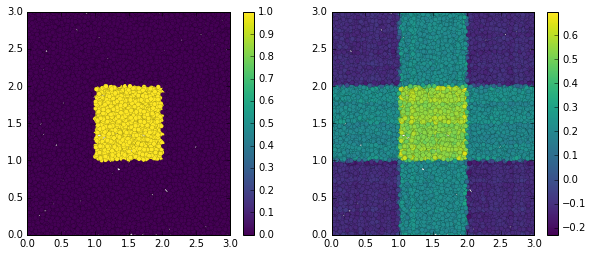

In [5]:
# experimental evidence that NFN is not a universal approximator
# changing number of rules doesn't affect the result in a better way

X = 3*np.random.rand(20000,2)
y = (X[:,0] > 1) & (X[:,0] <= 2) & (X[:,1] > 1) & (X[:,1] <= 2)
nfn = NeoFuzzyNeuron(n_rules = 100)
y_pred = nfn.fit_predict(X, y)

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c = y, lw = 0.1, cmap = 'viridis')
plt.xlim(0,3); plt.ylim(0,3)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c = y_pred, lw = 0.1, cmap = 'viridis')
plt.xlim(0,3); plt.ylim(0,3)
plt.colorbar()

Now let's talk about practical aspects of NFN applications. 

As was stated before, NFN-AR equivalence equations are ill-defined, as NFN has more degrees of freedom. In practice this also true for many other processes. The error surface is shallow, without a strict global minimum, and without regularization solvers produce inadequate results or even diverge. But even slightest L2-regularization solves the problem.

Another practical thing is training. Many papers propose to use first order gradient methods to minimize MSE loss to tune the NFN, and this can surely be done. But from the description of the model it follows, that after re-indexing it can be represented as linear model with respect to memberships instead of actual input signals:

$$NFN(\vec x) = \sum_{i=1}^{n} \sum_{j=1}^{m} w_{ij} \mu_{ij}(x_i) = \sum_{k=1}^{n \cdot m} w_k \mu_k(x_k)$$

Now we can see, that second order methods are more suited for this problem in general, and it is possible to natively apply plenty of existing linear solvers, which are blazingly fast, highly optimized and well tested. This will save significant amount of time when implementing NFN.

NFN can easily overfit in general. To do so, just increase the number of terms in the inference rules. This will make the underlying grid fine enough to exactly remember each value in the training sample. But overfitting in NFNs happens in a transparent and controllable way, unlike neural nets, for example, and can be easily accounted for. Also, solving a regularized task, as mentioned above, reduces the effect.

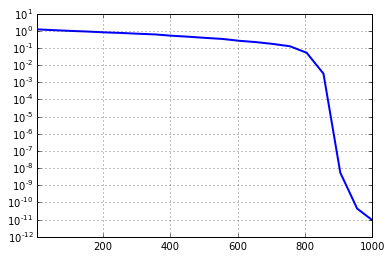

In [6]:
# overfitting example

t = np.linspace(0,10*np.pi,1000)
x = np.sin(t) + np.random.randn(t.size)
D = rollwin(x, 3)
X, y = D[:,:-1], D[:,-1]

def mse(x, y):
    return np.mean(np.square(x - y))

range_rules = np.arange(5, 1050, 50)
    
error = list()
for i in range_rules:
    nfn = NeoFuzzyNeuron(n_rules = i, solver = Ridge(alpha = 1e-8))
    y_pred = nfn.fit_predict(X, y)
    error.append(mse(y, y_pred))

plt.semilogy(range_rules, error, lw = 2)
plt.grid()
plt.xlim(5,1000);

Another topic is membership function form. Initially complementary triangular functions were proposed, but there are also lots of types of membership functions, smooth and non-smooth (trapezoidal, gaussian, generalized bell-shaped, cubic splines etc.). Though it might be appealing to use some smooth functions, but in practice it seems, that linear approximations provided by triangular MFs are good enough and compute much faster than gaussians, for example.

One small point is about sparsity. When moving to a linear optimization task, what is minimized is the norm $|| M\vec{w} - \vec{y}||_2$, where matrix $M_{N \times n \cdot m}$ is composed of memberships of input variables. As one point in the training sample can occupy only one fuzzy set in the input domain and activates only two neighboring MFs, approximately $N n (m - 2)$ of the entries ($n$ being the dimension of the input space and $m$ - the number of terms in each rule) in the matrix $M$ are zeros. So it is possible to apply solvers designed for sparse matrices and also store the data more efficiently.

In [7]:
N = 10000
n = 12
m = 15
X = np.random.rand(N, n)
grid = uniform_grid(X, m)
mfunc = get_sym_mfunc(grid)
M = mfunc(X)
print("Sparsity of M:")
print("Theoretical:\t%.2f%%" % (N*n*(m - 2) / (N*n*m) * 100))
print("Actual: \t%.2f%%" % ((M == 0).sum() / M.size * 100))

Sparsity of M:
Theoretical:	86.67%
Actual: 	86.73%


One important topic is a selection of a fuzzy partitioning of the input space. Two obvious schemes are uniform grid (notes are placed uniformly) and quantile grid (nodes are places in uniformly spaces quantiles). Latter has more nodes in the regions of higher density. But the knowledge of the domain is very important here. If you know operating regions of the modelled signal, you can gain much better accuracy. Here also NFN's interpretability comes in. While being non-linear, it's quite easy to understand NFN's decisions. Each inference rule's membership function can be plotted out, and it's easy to extract dynamics, described by each term in the rule. Fuzzy logic interpretation also can be naturally applied. 

Let's demonstrate how domain knowledge can be incorporated into the structure of the neo-fuzzy neuron and how it's parameters can be interpreted. Let's generate some piecewise-linear AR(1) using the following dynamics:

$$x_t = \begin{cases}
    0.9 x_{t-1}, & x_{t-1} < -0.1, \\
    -x_{t-1}, & -0.1 < x_{t-1} < 0 \\
    1.1 x_{t-1}, & 0 < x_{t-1} < 1, \\
    -x_{t-1}, & x_{t-1} > 1  
   \end{cases}$$
   
For demonstration purposes we aren't adding noise to this procee. From its form we can conclude, that points -0.1, 0 and 1 are points of change of the dynamics. The process exponentially decays / grows in most of the domain except for two critical points, where it changes it's sign abruptly. As we know, NFN is a piecewise AR model, which parameters are defined by the slope of the membership in the corresponding regions. These regions are $(-\infty,-0.1]$, $(-0.1, 0.0]$, $[0.1, 1)$ and $[1,+\infty)$. So this is our partitioning of the input space. But the process has discontinuities in the points -0.1 and 1, so we need to add two small partitions $(-0.1-\epsilon, -0.1]$ and $(1-\epsilon, 1]$, where $\epsilon$ is some small constant. These are regions where the fast transition will happen. 

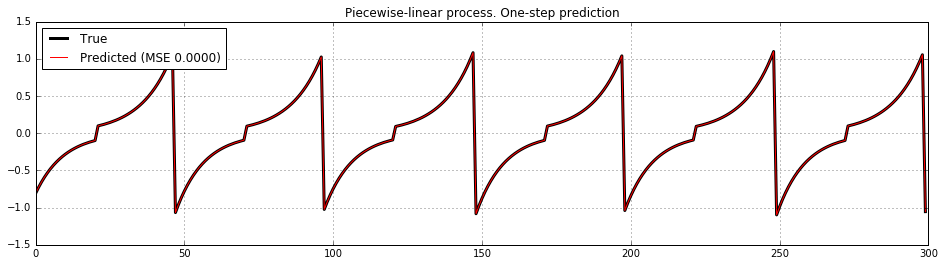

In [8]:
# partitioning and interpetability example

def generate_process(n):
    x = -1.0*np.ones(n)
    k = 1
    for i in range(n):
        x[i] =  1.1 * x[i-1] if 0 < x[i-1] < 1 else \
               -1.0 * x[i-1] if x[i-1] > 1 else \
               -1.0 * x[i-1] if x[i-1] > -0.1 else \
                0.9 * x[i-1]
    return x   

x = generate_process(10000)
D = rollwin(x, 2)
X, y = D[:,:-1], D[:,-1]

# custom grid construction for a described process
# left and right boundaries are added to the grid, as NFN process must be bounded
# epsilon = 1e-4

grid = np.array([[-2.0, -1.5, -0.1001, -0.1, 0.0, 0.9999, 1.0000, 1.5, 2.0]]).T
nfn = NeoFuzzyNeuron(grid = grid)
y_pred = nfn.fit_predict(X, y)

plt.figure(figsize = (16,4))
plt.title("Piecewise-linear process. One-step prediction")
plt.plot(y[:300], 'k-', lw = 3, label = 'True')
plt.plot(y_pred[:300], 'r-', label = 'Predicted (MSE %.4f)' % mse(y, y_pred))
plt.legend(loc = 'best')
plt.grid()

We've got a perfect reconstruction, as expected. This example also demonstrates the type of signals which NFN can deal with. Now we'll try to interpred weights of the trained NFN. Let's look on the only inference rule:

Slopes:
[-1.5;-0.1]:  0.9000
[-0.1;-0.0]: -1.0000
[ 0.0; 1.0]:  1.1000
[ 1.0; 1.5]: -0.9997


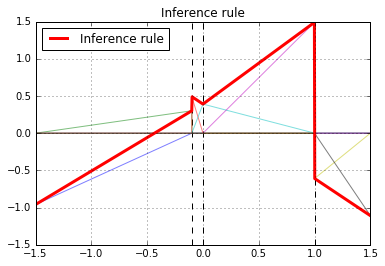

In [9]:
t = np.linspace(-1.5, 1.5, 1000)
M = nfn.mfunc(t.reshape((-1,1)))
W = nfn.weights_
c = nfn.c_
Y = W[None,:,:] * M

for i in range(M.shape[1]):
    plt.plot(t, Y[:,i,0], alpha = 0.5)
plt.plot(t, Y.sum(axis = (1,2)), 'r-', lw = 3, label = 'Inference rule')
plt.vlines([-0.1, 0, 1], -1.5, 1.5, 'k', 'dashed')

print("Slopes:")
print("[-1.5;-0.1]:  %.4f" % ((W[1] - W[0]) / (grid[2] - grid[1])))
print("[-0.1;-0.0]: %.4f"  % ((W[3] - W[2]) / (grid[4] - grid[3])))
print("[ 0.0; 1.0]:  %.4f" % ((W[4] - W[3]) / (grid[5] - grid[4])))
print("[ 1.0; 1.5]: %.4f"  % ((W[6] - W[5]) / (grid[7] - grid[6])))


plt.title("Inference rule")
plt.legend(loc = 'best')
plt.grid()

We can see all four transition regions on this plot. Straight line fron -1.5 to -0.1 means exponential decay, another straight line from 0.0 to 1.0 means exponential grown, and sharp shanges at -0.1 and 1.0 are switching points. Regions between -0.1 and 0.0 and also 1.0 and 1.5 revert sign of the signal. We can also see, that fitted values represent the same slopes as we designed initially.

Now let's run a standard benchmark on a Mackey-Glass series. This series is a solution to a Mackey-Glass equation - a nonlinear time delay differential equation with chaotic behaviour which comes from late 70-s physiology studies. This equation is often used for testing nonlinear time-series prediction models. We will compare results on the test set as well as dynamic (out-of-sample) prediction. Accuracy of the dynamic prediction is a good indicator of the quality of the model, as it shows how well the underlying process is reconstructed, and shows that fitted model can consistently generate valid samples. We will measure performance of the dynamic prediction as a weighted sum of squared errors, with weights being proportional to inverse square root of the future lag, so which are more distant in time make smaller contribution to the overall score. 

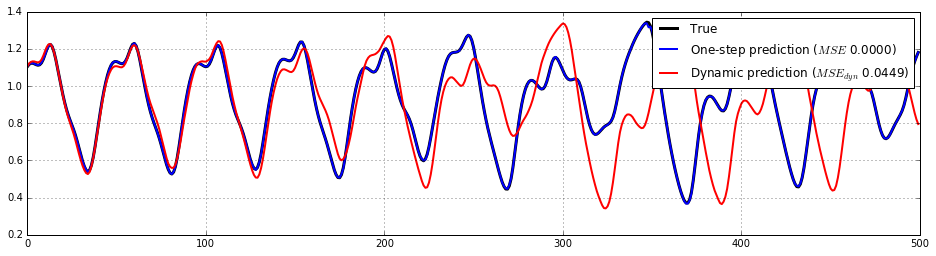

In [51]:
def mackey_glass(n, a = 0.2, b = 0.1, c = 10, d = 17):   
    x = 1 + np.random.rand(n+d)
    for i in range(d-1, n+d-1):
        x[i+1] = x[i] + a*x[i-d] / (1 + x[i-d]**c) - b*x[i]
    return x[d:]


def mse_dynamic(x, y):
    weights = 1.0 / np.sqrt(np.arange(1, len(x) + 1))
    weights /= weights.sum()
    return np.sum(weights * np.square(x - y))


N = 10000
K = int(0.7*N)
n_dyn = 500
n_inputs = 15
n_rules = 10

x = mackey_glass(N)
D = rollwin(x, n_inputs)
X, y = D[:,:-1], D[:,-1]
X_train, X_test, y_train, y_test = X[:K], X[K:], y[:K], y[K:]

nfn = NeoFuzzyNeuron(n_rules)
y_pred_train = nfn.fit_predict(X_train, y_train)
y_pred_test = nfn.predict(X_test)
y_pred_dyn = dynamic_predict(nfn, X_test[0,:], n_dyn)

mse_test = mse(y_pred_test, y_test)
mse_dyn = mse_dynamic(y_test[:n_dyn], y_pred_dyn[n_inputs-1:])

plt.figure(figsize = (16,4))
plt.plot(y_test[:n_dyn], 'k-', lw = 3, label = 'True')
plt.plot(y_pred_test[:n_dyn], 'b-', lw = 2, label = "One-step prediction ($MSE$ %.4f)" % mse_test)
plt.plot(y_pred_dyn[n_inputs-1:], 'r-', lw = 2, label = "Dynamic prediction ($MSE_{dyn}$ %.4f)" % mse_dyn)
plt.legend(loc = 1)
plt.grid()

We can see that without noise NFN is capable to perfectly reconstruct the time series for one-step prediction and has quite low errors of the dynamic prediction. Though the series is chaotic and heavily depends on the initial conditions, NFN can make precisely forecast it for first tens of steps and being quite accurate in predicting overall shape of the signal for first 100-150 points. But let's add some noise, as there is exist no real signal without noise. We will add additive gaussian noise with varying sigma. 

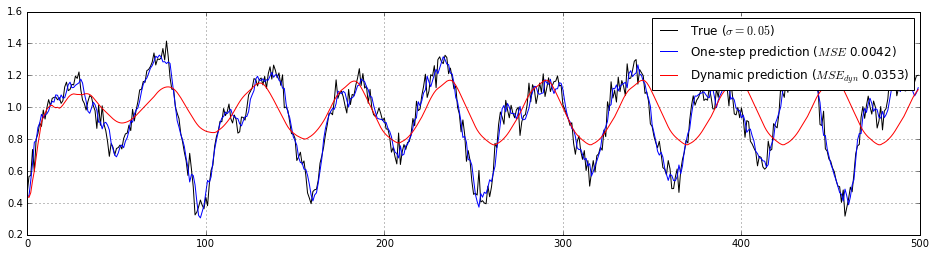

In [62]:
N = 10000
K = int(0.7*N)
n_dyn = 500
n_inputs = 15
n_rules = 10
sigma = 0.05

x = mackey_glass(N) + sigma * np.random.randn(N)
D = rollwin(x, n_inputs)
X, y = D[:,:-1], D[:,-1]
X_train, X_test, y_train, y_test = X[:K], X[K:], y[:K], y[K:]

nfn = NeoFuzzyNeuron(n_rules)
y_pred_train = nfn.fit_predict(X_train, y_train)
y_pred_test = nfn.predict(X_test)
y_pred_dyn = dynamic_predict(nfn, X_test[0,:], n_dyn)

mse_test = mse(y_pred_test, y_test)
mse_dyn = mse_dynamic(y_test[:n_dyn], y_pred_dyn[n_inputs-1:])

plt.figure(figsize = (16,4))
plt.plot(y_test[:n_dyn], 'k-', lw = 1, label = 'True ($\sigma = %.2f$)' % sigma)
plt.plot(y_pred_test[:n_dyn], 'b-', lw = 1, label = "One-step prediction ($MSE$ %.4f)" % mse_test)
plt.plot(y_pred_dyn[n_inputs-1:], 'r-', lw = 1, label = "Dynamic prediction ($MSE_{dyn}$ %.4f)" % mse_dyn)
plt.legend(loc = 1)
plt.grid()

As expected, results are less accurate, but still one-step prediction follows the true signal pretty good, lagging some times, and for moderate values of $\sigma$ several first points of dynamic prediction are decently predicted. Also restored dynamics is much simpler now and reduces basically to some simple sine-like oscillation converging to an average.

[1] T. Yamakawa, E. Uchino, T. Miki and H. Kusanagi, "A neo fuzzy neuron and its applications to system identification and prediction of the system behavior," Proc. 2nd Int. Conf. on Fuzzy Logic and Neural Networks, pp. 477-483, 1992.